<a href="https://colab.research.google.com/github/Konstvv/iBio-Summer-School/blob/main/Summer_school_PPI_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Protein-Protein Interaction prediction using Keras

by Konstantin Volzhenin

27/07/2022

# Contents
- Introduction
- Dataset
- Protein representations and embeddings
- PPI prediction model
- Data Analysis


# Introduction

## 1. PPI Networks

**Protein–protein interactions (PPIs)** are physical contacts established between two or more protein molecules as a result of biochemical events steered by various physical interactions. When studying a given organism (or an ecosystem with multiple organisms) the PPIs are usually combined together to form a protein-protein interaction network. Such networks or interactomes are of a great interest because of their value in different areas of protein related research (e.g. search for potential protein targets in therapeutic interest).


---

<p align="center">
  <img src="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4898894/bin/npjschz201612-f2.jpg" />
</p>

<center>
Fig. 1 Schizophrenia interactome
</center>
    
    Image taken from: Ganapathiraju MK, Thahir M, Handen A, Sarkar SN, Sweet RA, Nimgaonkar VL, Loscher CE, Bauer EM, Chaparala S (April 2016). "Schizophrenia interactome with 504 novel protein-protein interactions". NPJ Schizophrenia. 2: 16012.

---


## 2. Protein-protein interactions task - binary classification

During this class we will create a Deep Learning architechture for PPI prediction. The task itself is a binary classification: we have two sequences as an input and the model would have to estimate the probability of these two proteins to interact (a number between 0 and 1).

# Dataset
During this class we will work with PPI data
of yeast *Saccharomyces cerevisiae*. An
independent data set of 11 474 yeast PPIs contains approximately equal number of interacting and non-interacting pairs.

    Reference: Guo,Y. et al. (2008) Using support vector machine combined with auto covariance to predict protein–protein interactions from protein sequences. Nucleic Acids Res., 36, 3025–3030.

The dataset is composed of two files:

> **1. Interactions**

  Each entry contains two protein IDs and a binary label (1 - two given proteins interact, 0 - do not interact)


> **2. Dictionary**

  Contains protein IDs and corresponding protein sequences.
<br>
<br>
Using [this link](https://drive.google.com/drive/folders/1faC0YxAEfMBIWdtKIR-F33fSfFj6fL2T?usp=sharing), please download the dataset to your Colab folder.

Before working with a model we have to upload and preprocess the data.



Let's open the two downloaded files as DataFrames using Pandas and see what they look like:

In [2]:
!git clone https://github.com/Konstvv/iBio-Summer-School
import pandas as pd
import numpy as np

data = pd.read_csv('iBio-Summer-School/Interactions.tsv', sep='\t')
dict_seq = pd.read_csv('iBio-Summer-School/Dictionary.tsv', sep='\t')

print(data)
print(dict_seq)

Cloning into 'iBio-Summer-School'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 16 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.
         Seq1    Seq2  Label
0      P53049  P09435      1
1      Q08949  P38089      1
2      P02293  P00560      1
3      P53199  P53043      1
4      P47093  P37370      1
...       ...     ...    ...
11183  Q08980  O14467      0
11184  Q08931  P26188      0
11185  Q03792  P21651      0
11186  P53743  P34218      0
11187  P36057  P31111      0

[11188 rows x 3 columns]
          Id                                         Seq_string
0     O13297  MSYTDNPPQTKRALSLDDLVNHDENEKVKLQKLSEAANGSRPFAEN...
1     O13530  MGYTLFRFIVPFNPYFSSFYPSFPFYLSFPFCPSFPSFLSFPSSIF...
2     O13539  MTKEEGRTYFESLCEEEQSLQESQTHLLNILDILSVLADPRSSDDL...
3     O13553  MGQQRRSPLETVFLPLPSSQTTSTHAIAHFVLPACLFYSRSIFDHW...
4     O13554  MRHCIIFIVCISIVEIRTVH

# Protein representations and embeddings

The neural network cannot process the protein sequence represented by a string. In order to overcome this issue we have to find a way how to represent any given sequence numerically. In this class we will consider a couple of potential options



First of all let's evaluate the length distribution of our sequences in the dataset. Using *plt.hist* plot the sequence length distribution from *dict_seq*:

1    5594
0    5594
Name: Label, dtype: int64


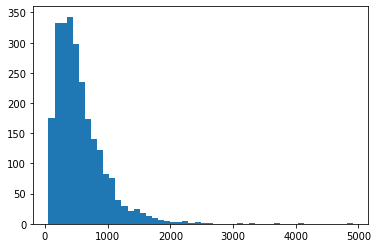

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print(data['Label'].value_counts())

plt.hist(dict_seq['Seq_string'].str.len(), bins=50)
plt.show()

In [ ]:
## Introducing a couple of parameters

# The sequence size for our future model
# All the sequences will be either trimmed or extended to this size
sequence_size = 2000  #@param {type: "slider", min: 100, max: 4000}

# Vocabulary of aminoacids
aminoacids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

## 1. One-hot embedding

The features are encoded using a ‘one-of-K’ or ‘dummy’ scheme. Every letter is replaced by a vector of size *len(aminoacids)* which is filled with 0 with only one value (at position *aminoacids.index(letter)*) being 1.

Please write a function **one_hot_emb** that takes a protein sequence as a string input and returns a one-hot array with the size *(sequence_size, len(aminoacids))*. If the string is longer than *sequence_size*, delete the excess (shorter - pad the rest with zeros).

In [ ]:
def one_hot_emb(string):
    # A shape that will be used for every one-hot embedding
    seq_tensor = np.zeros((sequence_size, len(aminoacids)), dtype=np.float16)
    for i in range(len(string)):
        char = string[i]
        if char in aminoacids:
            seq_tensor[i, aminoacids.index(char)] = 1
        if i == sequence_size - 1:
            break
    return seq_tensor


## 2. NLF embedding

This method takes many physicochemical properties and transforms them using PCA (dimensionality reduction method) and Fisher transformation creating a small set of features that can describe an amino acid. There are 18 transformed features in total.

    Reference: L. Nanni and A. Lumini, “A new encoding technique for peptide classification,” Expert Syst. Appl., vol. 38, no. 4, pp. 3185–3191, 2011.

We can upload a DataFrame that contains the transrormed vectors for all the corresponding amino acids:

In [ ]:
nlf = pd.read_csv('https://raw.githubusercontent.com/dmnfarrell/epitopepredict/master/epitopepredict'
                        '/mhcdata/NLF.csv', index_col=0)
# The letter X will represent an empty position (added in case we might encounter empty spots somewhere)
nlf['X'] = [0.0] * nlf.shape[0]
# If we encounter Selenocysteine, we'll treat it as Cysteine
nlf['U'] = nlf['C']
print(nlf)

       A     R     N     D     C     Q     E     G     H     I  ...     M  \
1   0.42  1.65  1.68  0.81  2.70  1.71  1.56  1.32  0.13  1.52  ...  1.72   
2   2.07  1.40  0.30  0.13  0.32  1.11  0.48  2.05  1.50  0.45  ...  0.85   
3   0.67  0.01  0.49  1.36  1.19  0.08  0.87  0.60  1.22  0.39  ...  0.34   
4   0.01  0.88  0.15  0.63  1.37  0.15  0.02  0.31  0.52  0.36  ...  0.44   
5   1.10  0.08  0.09  0.15  0.04  0.11  0.07  0.61  1.14  0.01  ...  0.01   
6   0.32  0.07  0.59  0.10  0.18  0.45  0.13  0.58  0.45  0.55  ...  0.80   
7   0.20  0.60  0.06  0.45  0.64  0.11  0.22  0.00  0.13  0.06  ...  0.16   
8   0.09  0.53  0.02  0.31  0.21  0.08  0.15  0.30  0.04  0.10  ...  0.05   
9   0.20  0.10  0.14  0.10  0.26  0.02  0.09  0.44  0.10  0.02  ...  0.05   
10  0.09  0.01  0.00  0.03  0.35  0.25  0.10  0.14  0.07  0.08  ...  0.30   
11  0.11  0.09  0.14  0.15  0.02  0.12  0.04  0.18  0.11  0.10  ...  0.29   
12  0.15  0.07  0.09  0.02  0.11  0.25  0.05  0.12  0.13  0.12  ...  0.06   

Here please write a function **nlf_emb** which would be similar to *one_hot_emb* and would take a protein sequence as an input and return an array with the size *(sequence_size, 18)* where each letter will be replaced by a vector taken from the *nlf* DataFrame

In [ ]:
def nlf_emb(string):
    seq_tensor = np.zeros((sequence_size, nlf.shape[0]), dtype=np.float16)
    for i in range(len(string)):
        seq_tensor[i] = np.array([nlf[string[i]]])
        if i == sequence_size - 1:
            break
    return seq_tensor

## 3. Blosum embedding

BLOSUM62 is a substitution matrix that specifies the similarity of one amino acid to another by means of a score. This score reflects the frequency of substiutions found from studying protein sequence conservation in large databases of related proteins. The number 62 stands for the percentage identity at which sequences are clustered in the analysis.

We can take columns of this matrix which correspond to a particular amino acid as embedding vectors. These way puts the amino acids with similar physicochemical properties closer together in the embedding space.

In [ ]:
blosum = pd.read_csv('https://raw.githubusercontent.com/dmnfarrell/epitopepredict/master/epitopepredict'
                        '/mhcdata/blosum62.csv', index_col=0)
# If we encounter Selenocysteine, we'll treat it as Cysteine
blosum['U'] = blosum['C']
# We will not encounter B, Z or * so we can delete the corresponding vectors
blosum.drop(labels=['B', 'Z', 'X', '*'], axis=0, inplace=True)
blosum.drop(labels=['B', 'Z', '*'], axis=1, inplace=True)
print(blosum)

   A  R  N  D  C  Q  E  G  H  I  ...  M  F  P  S  T   W  Y  V  X  U
A  4 -1 -2 -2  0 -1 -1  0 -2 -1  ... -1 -2 -1  1  0  -3 -2  0  0  0
R -1  5  0 -2 -3  1  0 -2  0 -3  ... -1 -3 -2 -1 -1  -3 -2 -3 -1 -3
N -2  0  6  1 -3  0  0  0  1 -3  ... -2 -3 -2  1  0  -4 -2 -3 -1 -3
D -2 -2  1  6 -3  0  2 -1 -1 -3  ... -3 -3 -1  0 -1  -4 -3 -3 -1 -3
C  0 -3 -3 -3  9 -3 -4 -3 -3 -1  ... -1 -2 -3 -1 -1  -2 -2 -1 -2  9
Q -1  1  0  0 -3  5  2 -2  0 -3  ...  0 -3 -1  0 -1  -2 -1 -2 -1 -3
E -1  0  0  2 -4  2  5 -2  0 -3  ... -2 -3 -1  0 -1  -3 -2 -2 -1 -4
G  0 -2  0 -1 -3 -2 -2  6 -2 -4  ... -3 -3 -2  0 -2  -2 -3 -3 -1 -3
H -2  0  1 -1 -3  0  0 -2  8 -3  ... -2 -1 -2 -1 -2  -2  2 -3 -1 -3
I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  ...  1  0 -3 -2 -1  -3 -1  3 -1 -1
L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  ...  2  0 -3 -2 -1  -2 -1  1 -1 -1
K -1  2  0 -1 -3  1  1 -2 -1 -3  ... -1 -3 -1  0 -1  -3 -2 -2 -1 -3
M -1 -1 -2 -3 -1  0 -2 -3 -2  1  ...  5  0 -2 -1 -1  -1 -1  1 -1 -1
F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  ...  0  6 -4 -2

Here please write a function **blosum_emb** which would be similar to *one_hot_emb* and would take a protein sequence as an input and return an array with the size *(sequence_size, blosum.shape[0])*

In [ ]:
def blosum_emb(string):
    seq_tensor = np.zeros((sequence_size, blosum.shape[0]), dtype=np.float16)
    for i in range(len(string)):
        seq_tensor[i] = np.array([blosum[string[i]]])
        if i == sequence_size - 1:
            break
    return seq_tensor

> **4. Other models**

There are many other different ways of how one can create a sequence embedding. The ones that may provide a good performance can be heavier and more complicated than the examples we have today. For example, the good solutions are:


*   *Protein profiles*

Profiles are used to model protein families and domains. They are built by converting multiple sequence alignments into position-specific scoring systems (PSSMs). Amino acids at each position in the alignment are scored according to the frequency with which they occur.

*   *Pretrained protein language models*

Various neural networks can be used to compute the embeddings while being trained on a large number of proteins. Such algorithms may use different types of information: the structural and physicochemical similarity between proteins, pairwise residue contact maps for individual proteins, etc. Usually these methods can provide more generalized view than trainable embeddings inside the predictive model due to the fact that they have been trained on large amounts of data.  




Once we have written our embedding function we can use it to convert all the sequences in our protein dictionary into numpy arrays.
Let's replace the strings in the 'Seq_string' column of the *dict_seq* DataFrame with the corresponding embeddings using one of the functions above:

In [ ]:
dict_seq['Seq_string'] = dict_seq['Seq_string'].apply(blosum_emb)
print(dict_seq)

          Id                                         Seq_string
0     O13297  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....
1     O13530  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....
2     O13539  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....
3     O13553  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....
4     O13554  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....
...      ...                                                ...
2492  Q99382  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....
2493  Q99383  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....
2494  Q99385  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....
2495  Q99394  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....
2496  Q9URQ3  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....

[2497 rows x 2 columns]


Then, let's replace all the protein IDs in the *data* (columns 'Seq1' and 'Seq2') with corresponding matrices from the *dict_seq*:

In [ ]:
data = data.merge(dict_seq, left_on='Seq1', right_on='Id', how='left')
data = data.merge(dict_seq, left_on='Seq2', right_on='Id', how='left', suffixes=('1', '2'))

data = data[['Seq_string1', 'Seq_string2', 'Label']]

print(data)

                                             Seq_string1  \
0      [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   
1      [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   
2      [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   
3      [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   
4      [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   
...                                                  ...   
11183  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   
11184  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   
11185  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   
11186  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   
11187  [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....   

                                             Seq_string2  Label  
0      [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....      1  
1      [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....      1  
2      [[-1.0, -1.0, -2.0, -3.0, -1.0, 0.0, -2.0, -3....      1  
3      [[-1.0, 

# PPI prediction model
In this section we will create a binary classification model for PPI predition. We will do that using the keras module:

In [ ]:
from keras import layers
from keras import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import gc

gpus = tf.config.list_physical_devices('GPU')

# Making sure we use GPU and setting the memory gorwth
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

## 1. Input - Embedding

Here we need to transform the data into numpy arrays and split it into 3 parts: training, validation, and testing. We will use training dataset for the training itself. The validation data will be used to evaluate the performance of the model after each epoch and to choose the best configuration. It is also might be used to choose the optimal values of hyperparameters. The testing data will be used afterwards to make a conclusion about how well the model performs.

In [ ]:
from sklearn.model_selection import train_test_split

x1 = np.asarray(data['Seq_string1'].tolist(), dtype=np.float16)
x2 = np.asarray(data['Seq_string2'].tolist(), dtype=np.float16)
y = np.asarray(data['Label'].tolist(), dtype=np.float32)

x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x1, x2, y, test_size=0.2)
# x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split(x1_train, x2_train, y_train, test_size=0.1)

# Delete the variables we do not need anymore to free some RAM in case the notebook crashes
del data, dict_seq, x1, x2, y

In [ ]:
input_dimensions = (sequence_size, x1_train.shape[-1])

# Inputs
seq_input1 = layers.Input(shape=input_dimensions, name='seq1')
seq_input2 = layers.Input(shape=input_dimensions, name='seq2')

## 2. Siamese module

The first part of the Neural network is a so-called siamese module which process two sequences separately. It takes a keras Tensor as an input and outputs another Tensor after having done several manupulations. In this class the Siamese module will consist of three types of layers: Convolutional, MaxPool, and GRU. 

The following concepts will be explained in person during the class. 

Here below you can find a schematic gif of 1D convolution. It shows how exactly a filter is applied to the sequence to compute the output:

<p align="center">
  <img src="https://e2eml.school/images/conv1d/stride_2.gif" />
</p>

Write the function that processes a Tensor by using 3-4 Conv+MaxPool layers followed by a Bidirectional GRU. Make sure to initialize the layers globally and not inside the function itself, so when we call a function multiple times it would not create new instances:

In [ ]:
# Convolutional modules
filters = 96

conv01 = layers.Conv1D(filters, 11, activation="relu")
mp1 = layers.MaxPooling1D(3)
conv02 = layers.Conv1D(filters*2, 7, activation="relu")
mp2 = layers.MaxPooling1D(3)
conv03 = layers.Conv1D(filters*4, 3, activation="relu")
mp3 = layers.MaxPooling1D(3)
conv04 = layers.Conv1D(filters*2, 3, activation="relu")
mp4 = layers.MaxPooling1D(3)

gru = layers.Bidirectional(layers.CuDNNGRU(filters, return_sequences=False))
if not gpus:
    gru = layers.Bidirectional(layers.GRU(filters, return_sequences=False))

def siamese_propagation(x):
    x = conv01(x)
    x = mp1(x)

    x = conv02(x)
    x = mp2(x)

    x = conv03(x)
    x = mp3(x)

    x = conv04(x)
    x = mp4(x)

    x_gru = gru(x)
    return x_gru

## 3. Merging point

The information from two sequences has to be merged at some point to produce a coherent prediction that would depend on the information from both proteins. There are many different ways to do that, but here we will consider an element-wise multiplication because a Biderectional GRU layer will produce only a single value for any given filter.

## 4. Prediction module

Here we have to create a *forward* function that takes two protein embeddings as inputs, processes them with a siamese module, merges two tensors using element-wise multiplication, and then uses two Dense layers to generate final output for binary classification.

*NB: Do not forget to use the sigmoid activation function in the last layer.*

In [ ]:
def forward(left, right):
    left = siamese_propagation(left)
    right = siamese_propagation(right)

    merge = layers.multiply([left, right])

    # merge = layers.Dense(filters*2, activation='relu')(merge)
    merge = layers.Dropout(0.2)(merge)
    return layers.Dense(1, activation='sigmoid')(merge)

## What metrics to use?
One of the problems of training a model for PPI prediction is the fact that the datasets are often unbalanced (there are much more negative interactions that positive ones). That is why, sometimes metrics like binary accuracy or ROC AUC might be not the best choice to evaluate the model's performance. Even though here we use a balanced dataset, we will still try to use more reliable metrics.

Here we will write three custom loss finctions for the accuracy, F1 score, and the Matthews correlation coefficient (MCC). These metrics provide more reliable assesments for imbalanced data.

$$
MCC = \frac{TP × TN - FP × FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

$$
F_{1} = \frac{TP}{TP + \frac{1}{2}(FP + FN)}
$$

where $TP$ - true positives, $TN$ - true negatives, $FP$ - false positives, $FN$ - false negatives

The functions must take (y_true, y_pred) as two arguments, two tensors with shape (batch_size, 1) that represent the original labels and predictions respectively, and return a tensor


In [ ]:
# For better compatibility one can use keras backend functions instead of numpy
# For example K.sum instead of np.sum, K.round instead of np.round, etc.
import keras.backend as K

def f1(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    pred_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (pred_pos + K.epsilon())
    recall = tp / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def mcc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

def accuracy(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    return (tp + tn) / (tp + tn + fp + fn)

## The loss function

The classic loss function for binary classification problems is binary crossentropy. In this section we are going to write a function that will compute binary crossentropy having two tensors as an input (target values and predictions):

In [ ]:
def binary_crossentropy(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = - K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
    return loss

## The model initialization and training

After having prepared the architechture we can initialize the Model class and begin the learning on the preprocessed data:

In [ ]:
gc.collect()

model = Model(inputs=[seq_input1, seq_input2],
            outputs=[forward(seq_input1, seq_input2)])

adam = Adam(learning_rate=1e-4, amsgrad=True, epsilon=1e-6)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/content/model.h5', monitor='val_mcc', mode='max')
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

model.compile(optimizer=adam, loss=binary_crossentropy, metrics=[accuracy, f1, mcc])

model.fit([x1_train, x2_train], y_train, epochs=50, callbacks=[checkpoint_callback, earlystop_callback],
          batch_size=64, verbose=1, validation_split=0.15)

Epoch 1/50
119/119 [==============================] - 16s 103ms/step - loss: 0.6934 - accuracy: 0.5150 - f1: 0.4814 - mcc: 0.0380 - val_loss: 0.6872 - val_accuracy: 0.5607 - val_f1: 0.6207 - val_mcc: 0.1436
Epoch 2/50
119/119 [==============================] - 10s 83ms/step - loss: 0.6831 - accuracy: 0.5532 - f1: 0.5475 - mcc: 0.1397 - val_loss: 0.6755 - val_accuracy: 0.5533 - val_f1: 0.6276 - val_mcc: 0.1328
Epoch 3/50
119/119 [==============================] - 10s 88ms/step - loss: 0.6684 - accuracy: 0.5791 - f1: 0.6265 - mcc: 0.1788 - val_loss: 0.6682 - val_accuracy: 0.5697 - val_f1: 0.5690 - val_mcc: 0.1389
Epoch 4/50
119/119 [==============================] - 10s 83ms/step - loss: 0.6598 - accuracy: 0.5996 - f1: 0.6496 - mcc: 0.2212 - val_loss: 0.6645 - val_accuracy: 0.6047 - val_f1: 0.5873 - val_mcc: 0.2065
Epoch 5/50
119/119 [==============================] - 10s 83ms/step - loss: 0.6481 - accuracy: 0.6144 - f1: 0.6595 - mcc: 0.2487 - val_loss: 0.6543 - val_accuracy: 0.5964 - va

# Data Analysis


## 1. Model testing
In this section we are going to get the predictions of the test data and compute the metrics we have used before. Moreover, we can build ROC and PR curves to estimate these metrics as well.

In [ ]:
model_saved = tf.keras.models.load_model('/content/model.h5', custom_objects={'f1': f1, 'mcc': mcc})

y_pred = model_saved.predict([x1_test, x2_test]).flatten()

In [ ]:
print('Test accuracy: ', accuracy(y_test, y_pred).numpy())
print('Test F1 score: ', f1(y_test,  y_pred).numpy())
print('Test MCC score: ', mcc(y_test, y_pred).numpy())

Test accuracy:  0.94861484
Test F1 score:  0.9477035
Test MCC score:  0.89751726


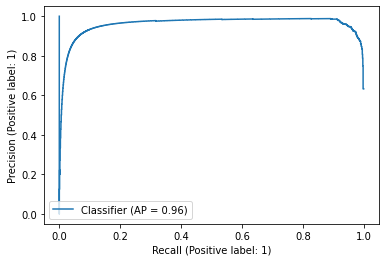

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.show()

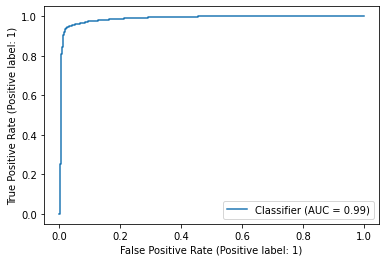

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

## 3. C1 - C2 - C3 classes

The accuracy of PPI predictions greatly vary depending on the training and testing data. In some [state-of-the-art models](http://cb.csail.mit.edu/cb/dscript/) one can observe that the model performance becomes significantly worse when we test the model using proteins from organisms that are not related to the training set. Therefore, the performance of the model can be evaluated slightly differently: we can divide our testing set into 3 groups: C1 - pairs where both proteins were in the training data, C2 - pairs where only one of the proteins is in the training data, C3 - pairs that do not contain proteins from training data at all.

In this section you need to manually create three separate testing sets for C1-C2-C3 classes and check whether the model performance is any different.

In [ ]:
import random

data = pd.read_csv('iBio-Summer-School/Interactions.tsv', sep='\t')
dict_seq = pd.read_csv('iBio-Summer-School/Dictionary.tsv', sep='\t')
dict_seq['Seq_string'] = dict_seq['Seq_string'].apply(blosum_emb)

samples = set(data['Seq1'].tolist()+data['Seq2'].tolist())

test_split = 0.05
# These proteins will only be used in a testing set
samples = random.sample(samples, int(len(samples) * test_split))

data_C3 = data.loc[data['Seq1'].isin(samples) & data['Seq2'].isin(samples)]
data_C2 = data.loc[(~data['Seq1'].isin(samples) & data['Seq2'].isin(samples)) | 
                   (data['Seq1'].isin(samples) & ~data['Seq2'].isin(samples))]

data_C1 = data.loc[~data['Seq1'].isin(samples) & ~data['Seq2'].isin(samples)]

del data

In [ ]:
def preprocess_dataset(data):
  data = data.merge(dict_seq, left_on='Seq1', right_on='Id', how='left')
  data = data.merge(dict_seq, left_on='Seq2', right_on='Id', how='left', suffixes=('1', '2'))

  data = data[['Seq_string1', 'Seq_string2', 'Label']]

  x1 = np.asarray(data['Seq_string1'].tolist(), dtype=np.float16)
  x2 = np.asarray(data['Seq_string2'].tolist(), dtype=np.float16)
  y = np.asarray(data['Label'].tolist(), dtype=np.float32)

  return x1, x2, y

x1, x2, y = preprocess_dataset(data_C1)
x1_C2, x2_C2, y_C2 = preprocess_dataset(data_C2)
x1_C3, x2_C3, y_C3 = preprocess_dataset(data_C3)

del data_C1, data_C2, data_C3

x1_train, x1_C1, x2_train, x2_C1, y_train, y_C1 = train_test_split(x1, x2, y, test_size=0.1)
# x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split(x1_train, x2_train, y_train, test_size=0.1)

In [ ]:
gc.collect()

model = Model(inputs=[seq_input1, seq_input2],
            outputs=[forward(seq_input1, seq_input2)])

adam = Adam(learning_rate=1e-4, amsgrad=True, epsilon=1e-6)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[accuracy, f1, mcc])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/content/model_C1_C2_C3.h5', monitor='val_loss', mode='min')
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit([x1_train, x2_train], y_train, epochs=50,
          batch_size=32, verbose=1, validation_split=0.15, callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/20
36/36 - 264s - loss: 0.6930 - accuracy: 0.5186 - f1: 0.4452 - mcc: 0.0393 - val_loss: 0.6929 - val_accuracy: 0.5035 - val_f1: 0.6634 - val_mcc: 0.0342 - 264s/epoch - 7s/step
Epoch 2/20
36/36 - 246s - loss: 0.6878 - accuracy: 0.5533 - f1: 0.5207 - mcc: 0.1274 - val_loss: 0.6831 - val_accuracy: 0.5794 - val_f1: 0.5837 - val_mcc: 0.1577 - 246s/epoch - 7s/step
Epoch 3/20
36/36 - 242s - loss: 0.6816 - accuracy: 0.5607 - f1: 0.5273 - mcc: 0.1295 - val_loss: 0.6796 - val_accuracy: 0.5828 - val_f1: 0.6508 - val_mcc: 0.1807 - 242s/epoch - 7s/step
Epoch 4/20
36/36 - 240s - loss: 0.6685 - accuracy: 0.5936 - f1: 0.5768 - mcc: 0.1955 - val_loss: 0.6696 - val_accuracy: 0.6089 - val_f1: 0.6422 - val_mcc: 0.2211 - 240s/epoch - 7s/step
Epoch 5/20
36/36 - 240s - loss: 0.6612 - accuracy: 0.6034 - f1: 0.6015 - mcc: 0.2389 - val_loss: 0.6716 - val_accuracy: 0.5717 - val_f1: 0.4960 - val_mcc: 0.1491 - 240s/epoch - 7s/step
Epoch 6/20
36/36 - 239s - loss: 0.6448 - accuracy: 0.6209 - f1: 0.6241 - mc

In [ ]:
model_saved = tf.keras.models.load_model('/content/model_C1_C2_C3.h5', custom_objects={'f1': f1, 'mcc': mcc})

y_pred_C1 = model_saved.predict([x1_C1, x2_C1]).flatten()
y_pred_C2 = model_saved.predict([x1_C2, x2_C2]).flatten()
y_pred_C3 = model_saved.predict([x1_C3, x2_C3]).flatten()

In [ ]:
print('C1 Test accuracy: ', accuracy(y_C1, y_pred_C1).numpy())
print('C2 Test accuracy: ', accuracy(y_C2, y_pred_C2).numpy())
print('C3 Test accuracy: ', accuracy(y_C3, y_pred_C3).numpy())

C1 Test accuracy:  0.9460208
C2 Test accuracy:  0.7772766
C3 Test accuracy:  0.5680191
